In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from scipy.stats import multivariate_normal

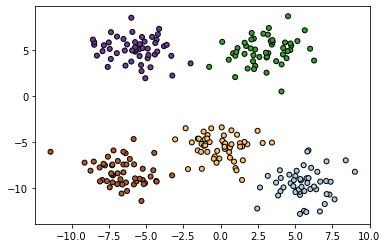

In [2]:
n_clusters = 5

X, Y = X, y = make_blobs(n_samples=[50 for _ in range(n_clusters)], n_features=2,
                  random_state=10, cluster_std=1.5)
plt.scatter(X[:, 0], X[:, 1], marker='o', c=Y,
            s=25, edgecolor='k', cmap=plt.cm.Paired)

In [3]:
def r_k(x, mean, cov, pi, k):
    
    a = pi[k] * multivariate_normal(mean[k], cov[k]).pdf(x)
    b = np.sum([pi[p] * multivariate_normal(mean[p], cov[p]).pdf(x) for p in range(pi.shape[0])])
    
    if b == 0:
        pass
    
    return a/b

def EM(X, K, mean_0, cov_0, pi_0, alphas, k_0, v_0, iter=10, debug=False):
    N, D = X.shape
    mean_prev = mean_0.copy()
    cov_prev = cov_0.copy()
    pi_prev = pi_0.copy()
    
    mean = mean_0.copy()
    cov = cov_0.copy()
    pi = pi_0.copy()
    
    for i in range(iter):
        if debug:
            print(f"Iteração {i} #############")
        for k in range(K): # para cada valor latente
            responsabilities = np.array([r_k(x_i, mean_prev, cov_prev, pi_prev, k) for x_i in X])
            sum_res = np.sum(responsabilities, axis=0) 
            # valor atualizado da probabilidade categórica de k
            pi[k] = (alphas[k] - 1 + sum_res) / (N - K + np.sum(alphas))
            
            # x_i ponderado pela responsabilidade
            x_k = responsabilities.dot(X) / sum_res
            mean[k,:] = (k_0 * mean_0[k,:] + x_k * sum_res) / (k_0 + sum_res)

            distances = responsabilities.dot(X - x_k)
            cov_k = (cov_0[k,:,:] + distances.T.dot(distances) + (k_0*sum_res / (k_0 + sum_res)) * np.outer(x_k - mean_0[k,:], x_k - mean_0[k,:]))
            cov_k = cov_k / (v_0 + D + 2 + sum_res)
            cov[k,:,:] =  cov_k
            
            if debug:
                print(f"Variavel latente {k}:")
                print(f"média: {mean[k]}")
                print(f"covariância:\n{cov[k]}\n\n")
                print(f"pi: {pi[k]}")
                print("-------------------------\n")
        
        mean_prev = mean.copy()
        cov_prev = cov.copy()
        pi_prev = pi.copy()

    return mean, cov, pi

In [4]:
def generate_normalized_initial_values(X, K, dim):
    mean_0 = X[np.random.choice(np.arange(X.shape[0]), K)]
    cov_0 = np.array([np.diag(np.var(X,axis=0)) for _ in range(K)])
    
    return mean_0, cov_0

K = n_clusters
mean_0, cov_0 = generate_normalized_initial_values(X, K=K, dim=X.shape[1])
pi_0 = np.array([1/K for _ in range(K)])
alphas = np.array([2 for _ in range(K)])

mean, cov, pi = EM(X, K, mean_0, cov_0, pi_0, alphas, 0, 4, iter=5, debug=False)

print("\n##########################\n")
print("Resultados finais: ")
for k in range(K):
    print(f"Variavel latente {k}:")
    print(f"média: {mean[k]}")
    print(f"covariância:\n{cov[k]}\n")
    print(f"pi: {pi[k]}")
    print("-------------------------\n")


##########################

Resultados finais: 
Variavel latente 0:
média: [ 1.32368442e-03 -5.51439977e+00]
covariância:
[[4.25352207e-01 1.90486695e-30]
 [1.90486695e-30 7.39623571e-01]]

pi: 0.19996193947446222
-------------------------

Variavel latente 1:
média: [-6.57943003 -8.25652785]
covariância:
[[4.25353497e-01 5.66547270e-28]
 [5.66547270e-28 7.39625814e-01]]

pi: 0.19996125003500487
-------------------------

Variavel latente 2:
média: [2.95490274 4.90735281]
covariância:
[[4.25281019e-01 1.91062871e-29]
 [1.91062871e-29 7.39499785e-01]]

pi: 0.20000000654020322
-------------------------

Variavel latente 3:
média: [ 5.57060475 -9.58542788]
covariância:
[[4.25137462e-01 3.14821903e-28]
 [3.14821903e-28 7.39250161e-01]]

pi: 0.20007681049053314
-------------------------

Variavel latente 4:
média: [-5.73397487  5.08740007]
covariância:
[[4.25281043e-01 1.14823468e-28]
 [1.14823468e-28 7.39499828e-01]]

pi: 0.19999999345979655
-------------------------



In [5]:
def get_prob(x, mean, cov, pi, with_k=False):
    K = mean.shape[0]
    responsabilities = np.array([r_k(x, mean, cov, pi, k) for k in range(K)])
    k = np.argmax(responsabilities)
    prob = multivariate_normal(mean[k], cov[k]).pdf(x)
    
    if with_k:
        return prob, k
    else:
        return prob

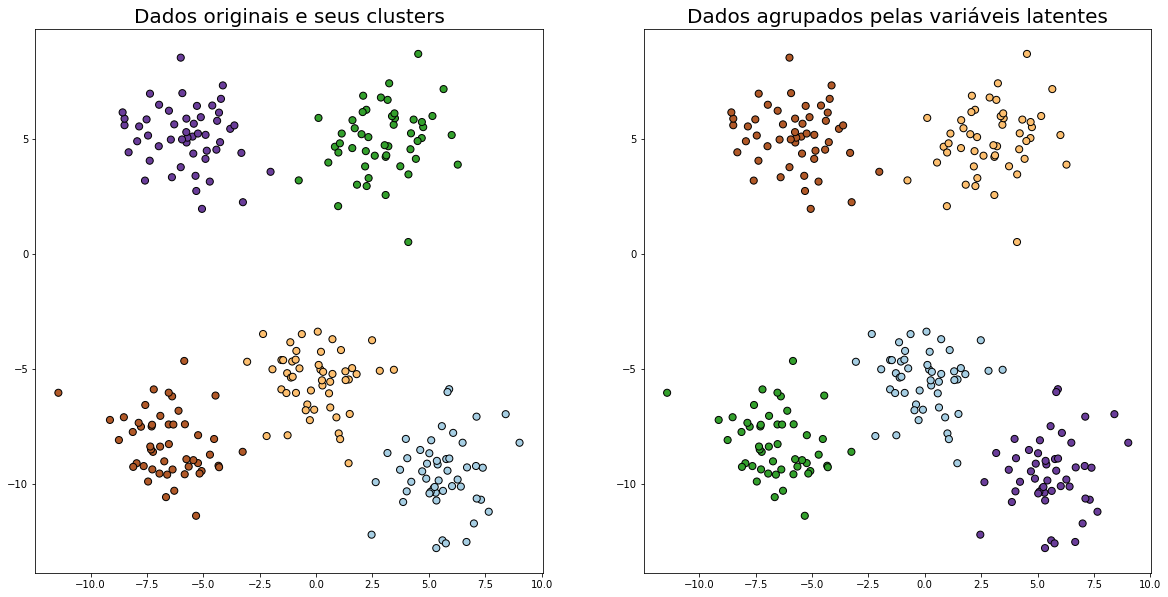

In [6]:
z = [get_prob(x, mean, cov, pi, with_k=True)[1] for x in X]

plt.figure(figsize=(20,10))

plt.subplot(1,2,1)
plt.scatter(X[:, 0], X[:, 1], marker='o', c=Y,
            s=50, edgecolor='k', cmap=plt.cm.Paired)
plt.title("Dados originais e seus clusters", fontsize=20)

plt.subplot(1,2,2)
plt.scatter(X[:, 0], X[:, 1], marker='o', c=z,
            s=50, edgecolor='k', cmap=plt.cm.Paired)
_ = plt.title("Dados agrupados pelas variáveis latentes", fontsize=20)

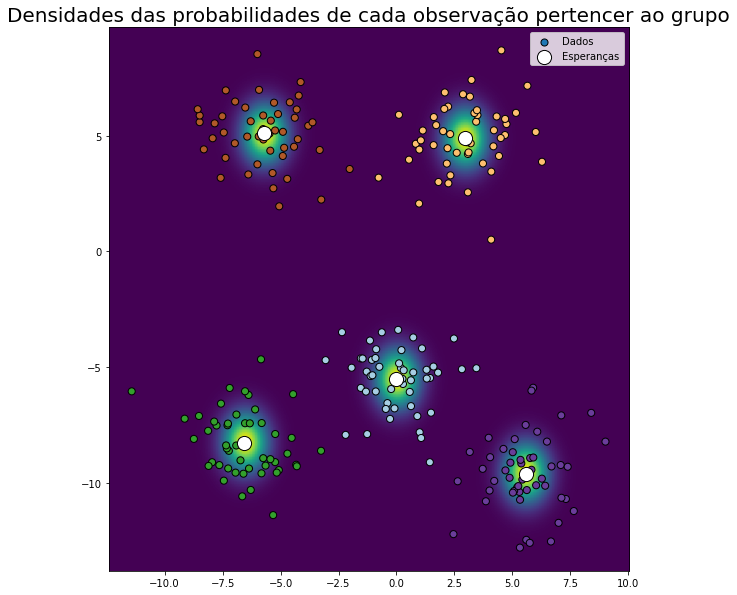

In [8]:
resolution = 200
margin = 1
x = np.linspace(X.min(axis=0)[0]-margin,X.max(axis=0)[0]+margin,resolution)
y = np.linspace(X.min(axis=0)[1]-margin,X.max(axis=0)[1]+margin,resolution)
grid = np.dstack(np.meshgrid(x,y)).reshape(-1,2)

densities = np.array([get_prob(x, mean, cov, pi) for x in grid]).reshape(resolution, resolution)

plt.figure(figsize=(10,10))
plt.imshow(densities, origin='lower', extent=(x[0],x[-1],y[0],y[-1]))
plt.scatter(X[:, 0], X[:, 1], marker='o', c=z,
            s=50, edgecolor='k', cmap=plt.cm.Paired, label="Dados")
plt.scatter(mean[:,0], mean[:,1], marker="o", c="w", s=200, edgecolors='k', label="Esperanças")
plt.title("Densidades das probabilidades de cada observação pertencer ao grupo", fontsize=20)
plt.legend()